In [1]:
from matplotlib import pyplot as plt
import numpy as np
import torch
import sys
sys.path.insert(0, '..')
from models import Classifier, WeightedMSE, FlatLoss
from utils import Metrics, find_threshold, DataSet, Logger

In [2]:
files = np.load("data/W_FCN_v0.npz")
train = files["train"].astype('float32')
val = files["val"].astype('float32')

maxdata = train.max(axis=0)
mindata = train.min(axis=0)
train = (train-mindata)/(maxdata-mindata)
maxdata = val.max(axis=0)
mindata = val.min(axis=0)
val = (val-mindata)/(maxdata-mindata)

In [3]:
traindataset = DataSet(samples=train[::,1:-1],
                       labels=train[::,-1].astype('int32'),
                       m = train[::,0])
valdataset = DataSet(samples=val[:,1:-1],
                     labels=val[:,-1].astype('int32'),
                    m = val[:,0])

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print('device:', device)

device: cpu


In [16]:
frac=0.9
print("strength",frac/(1-frac))
params = {'epochs'     : 400,
          'interval'   : 100,
          'batch_size' : 4096,
          'shuffle'    : True,
          'num_workers': 6,
          'drop_last'  :True,
          'device'     : device,
          'pass_x_biased':True,
         }
metrics_train_L = Metrics()
metrics_val_L = Metrics(validation=True)

strength 9.000000000000002


In [17]:
torch.manual_seed(69)
model_L = Classifier().to(device)
optimizer = torch.optim.SGD(model_L.parameters(),lr=1e-1,momentum=0.)
loss =  FlatLoss(labels=traindataset.labels,frac=frac)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=200, gamma=0.9)
log=Logger("./logs/logWFCNflatLoss.txt")
model_L.fit(traindataset=traindataset,
            valdataset=valdataset,
            optimizer=optimizer,
            loss=loss,
            **params,
            log=log,
          #scheduler=scheduler,
          metrics=[metrics_train_L,metrics_val_L])

Entering Training...
Epoch:0100/0400  (128.6s)
 Train: loss:0.0649, acc:74% || Val: loss: 0.0115, acc:44%, R50: 5.3208, 1/JSD: 6.6484
Epoch:0200/0400  (264.2s)
 Train: loss:0.0711, acc:75% || Val: loss: 0.0098, acc:44%, R50: 5.6176, 1/JSD: 5.4566
Epoch:0300/0400  (401.5s)
 Train: loss:0.0820, acc:76% || Val: loss: 0.0096, acc:45%, R50: 5.7169, 1/JSD: 5.7144
Epoch:0400/0400  (538.2s)
 Train: loss:0.0686, acc:76% || Val: loss: 0.0083, acc:44%, R50: 5.9818, 1/JSD: 5.6343


In [6]:
params = {'epochs' : 200,
          'interval'   : 100,
          'batch_size' : 4096,
          'shuffle'    : True,
          'num_workers': 6,
          'pass_x_biased':False
         }
metrics_train = Metrics()
metrics_val = Metrics(validation=True)

In [7]:
torch.manual_seed(69)
model = Classifier()
optimizer = torch.optim.SGD(model.parameters(),lr=2e-1,momentum=0.)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=200, gamma=0.9)
criterion = WeightedMSE(labels=traindataset.labels)
log=Logger("./logs/logWFCNmse.txt")
model.fit(traindataset=traindataset,
          valdataset=valdataset,
          **params,
          optimizer= optimizer,
          loss=criterion,
          log=log,
          #scheduler=scheduler,
          metrics=[metrics_train,metrics_val])

Entering Training...
Epoch:0100/0200  (118.0s)
 Train: loss:0.1891, acc:79% || Val: loss: 0.0335, acc:83%, R50: 22.4368, 1/JSD: 3.5423
Epoch:0200/0200  (243.5s)
 Train: loss:0.1876, acc:80% || Val: loss: 0.0305, acc:83%, R50: 23.9148, 1/JSD: 3.3657


In [8]:
test = files["test"]
maxdata = test.max(axis=0)
mindata = test.min(axis=0)
test = (test-mindata)/(maxdata-mindata)

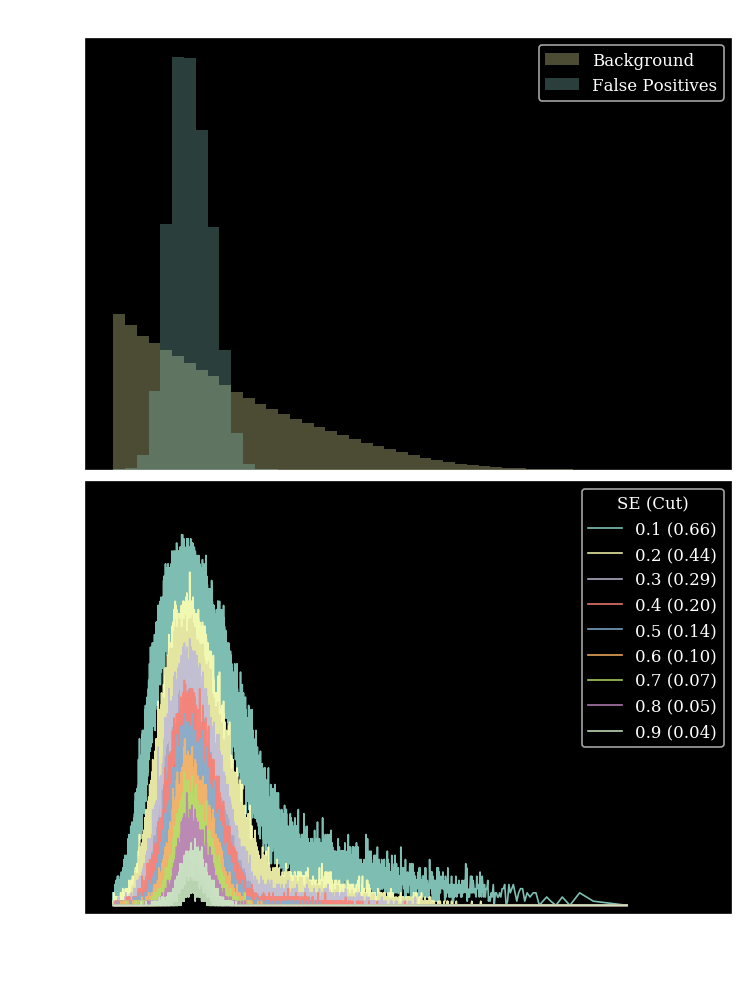

In [9]:
 def plot_stuff(model,X,y,x_biased,name='Naive DNN'):
    predictions = np.array(model(torch.Tensor(X).float()).tolist()).flatten()
    metrics_test = Metrics(validation=True)
    metrics_test.calculate(pred=predictions, target=y,m=x_biased)
    R50 = metrics_test.R50[0]
    JSD = metrics_test.JSD[0]

    c = find_threshold(predictions,(y==0),0.5)
    fig, [ax,ax1] = plt.subplots(2,1,figsize=(6,8),dpi=120,sharex=True)
    _,bins,_ = ax.hist(x_biased[(y==1)],bins=50,alpha=0.3,color='C1',label='Background',density=True)
    ax.hist(x_biased[(y==1)&(predictions<c)],bins=bins,alpha=0.3,color='C0',label='False Positives',density=True)
    ax.set_ylabel("Normed Counts",fontsize=20)
    ax.set_title('{} (R50:{:.2f}, 1/JSD:{:.2f})'.format(name,R50,1/JSD))
    ax.legend()

    efficiencies = np.linspace(0.1,0.9,9)
    cuts = []
    for eff in efficiencies:
        cuts.append(find_threshold(predictions,(y==0),eff))
    m_t = x_biased
    sorted_m = np.argsort(m_t)
    scores = predictions[sorted_m].reshape(-1,100)
    m_t = m_t[sorted_m]
    m = m_t.reshape(-1,100).mean(axis=1)
    F_s = []
    for s in scores.reshape(50,-1):
        density = np.histogram(s,bins=50,range=(0,1))[0]
        F_s.append(np.cumsum(density)/density.sum())
    F_s = np.array(F_s).T
    for j,cut in enumerate(cuts):
        c = f"C{j}" #if j!= 6 else f"C11"
        passed = (scores<cut).sum(axis=1)/scores.shape[1]
        ax1.plot(m,passed,label="{:0.1f} ({:0.2f})".format(efficiencies[j],cut),alpha=0.9,c=c,lw=1)
    ax1.set_ylabel(r"$\mathrm{passing\, events}/\mathrm{events\,in\, bin}$",fontsize=14)
    ax1.set_ylim([-0.02,1.02])
    ax1.legend(loc='upper right', bbox_to_anchor=(1,1) ,markerscale=5,title="SE (Cut)",ncol=1)
    ax1.set_xlabel(r"$m$",fontsize=14)
    fig.tight_layout(pad=0)
    plt.show()
plot_stuff(model=model,name="Naive DNN",X=test[:,1:11],y=test[:,-1],x_biased=test[:,0])

/home/kitouni/anaconda3/envs/root3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()
/home/kitouni/anaconda3/envs/root3.7/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide
/home/kitouni/anaconda3/envs/root3.7/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in less


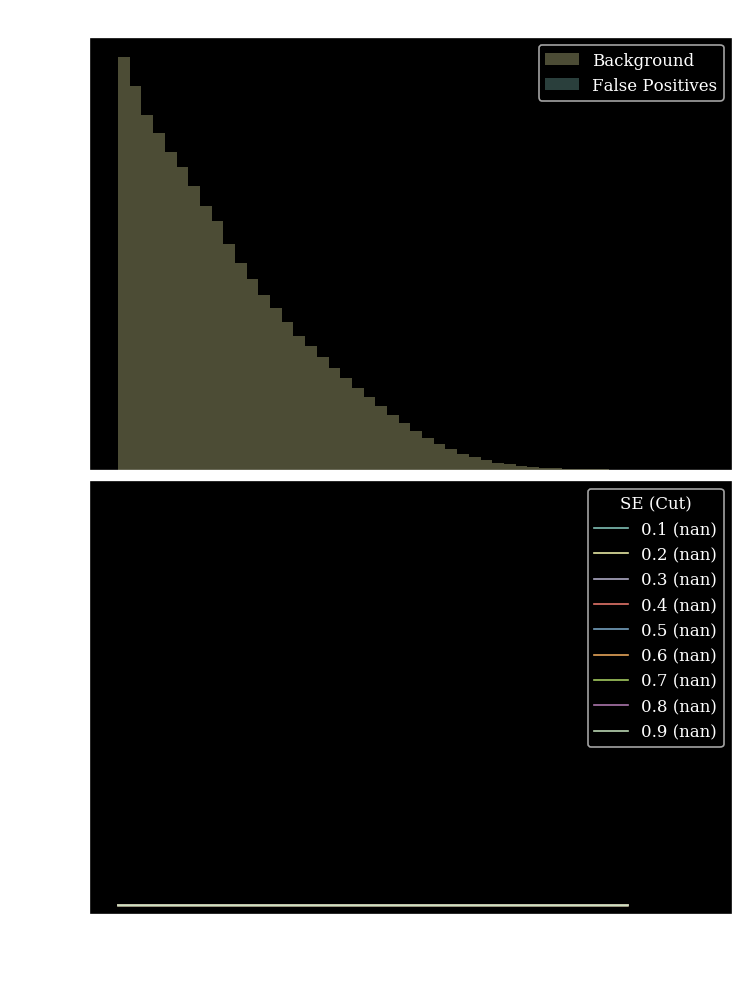

In [14]:
plot_stuff(model=model_L,name="FlatLoss DNN",X=test[:,1:11],y=test[:,-1],x_biased=test[:,0])